# imports

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys, os, time
sys.path.append('/mnt/home/cmodi/.local/lib/python3.8/site-packages/')

In [4]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
import sbi
import torch
import wandb
from wandb import Api
import zeus
import emcee


In [7]:
sys.path.append('../src/')

import loader_pk
import sbitools, sbiplots
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [8]:
args = {"kmin": 0.15, "kmax":0.5, "offset_amp":0, "ampnorm":False, "alg":"snpe"}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)

Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 56)



# SNPE with matter spectra

In [10]:
### SBI
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
trainy = params.copy()
prior = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
posterior, inference, summary = sbitools.sbi(trainx, trainy, prior, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8, alg='snpe')

Training a new NF
 Neural network successfully converged after 159 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 159
        Best validation performance: 12.2322
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

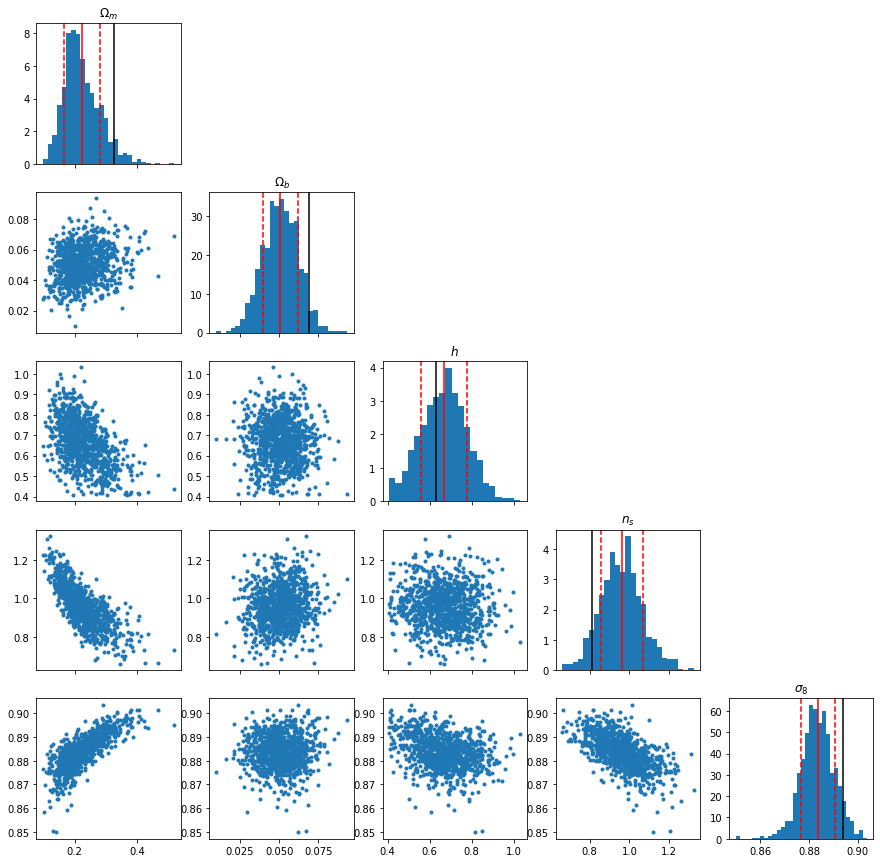

In [13]:
i = 3
fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)

In [206]:
nsims, nsamples = 100, 1000
samples = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(100):
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

<ErrorbarContainer object of 3 artists>

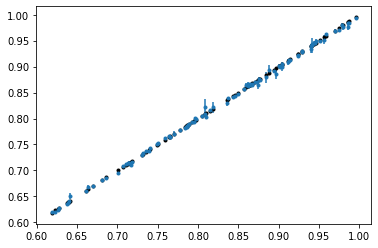

In [207]:
j = 4
plt.plot(params[:nsims, j], params[:nsims, j], 'k.')
plt.errorbar(params[:nsims, j], samples.mean(axis=1)[:, j], samples.std(axis=1)[:, j], fmt='.')



# SNLE with matter spectra

In [145]:
from sbi.inference import SNLE_A
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn


In [33]:
args = {"kmin": 0.001, "kmax":0.5, "offset_amp":0, "ampnorm":False}
args = sbitools.Objectify(args)
kcut, features, params = loader_pk.loader(args, return_k=True)
trainx, scaler = sbitools.standardize(features, secondary=None, log_transform=True)
trainy = params.copy()


Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 79)


In [251]:
sbi.utils.BoxUniform()

BoxUniform(Uniform(low: torch.Size([5]), high: torch.Size([5])), 1)

In [262]:
prior = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2, device='cpu')
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference.append_simulations(x= torch.from_numpy(trainx.astype('float32')), 
                            theta= torch.from_numpy(trainy.astype('float32')))

density_estimator = inference.train(training_batch_size=16,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference.build_posterior(density_estimator)



 Neural network successfully converged after 135 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 135
        Best validation performance: 152.1078
        -------------------------
        


In [264]:
# j = 0 
# nsamples = 500 
# x = trainx[j].copy()
# samples_nle = posterior_nle.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=True).detach().numpy()


In [265]:

from sbi.inference import likelihood_estimator_based_potential
potential_fn, parameter_transform = likelihood_estimator_based_potential(
                                                                        density_estimator, 
                                                                        prior, 
                                                                        torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))

def log_prob(x):
    return potential_fn(torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # loglik =  density_estimator.log_prob(torch.from_numpy(y.reshape(1, -1).astype(np.float32)), context=torch.from_numpy(x.reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # logprior = prior.log_prob(torch.from_numpy(trainy[0].reshape(1, -1).astype(np.float32))).detach().numpy()[0]
    # return loglik + logprior
    
data = trainx[0].copy()
nsteps, nwalkers, ndim = 500, 20, 5
x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
print(log_prob(trainy[0]))

# start = time.time()
# sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)
# sampler.run_mcmc(x0, nsteps, progress=True)
# chain = sampler.get_chain(flat=False, discard=0.2);
# print("Time taken = ", time.time() - start)


start = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(x0, nsteps, progress=True)
chain = sampler.get_chain(flat=False, discard=int(0.2*nsteps));
print("Time taken = ", time.time() - start)

154.67134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.07it/s]

Time taken =  22.71259379386902


In [257]:
# from sbi.inference import likelihood_estimator_based_potential
# potential_fn, parameter_transform = likelihood_estimator_based_potential(
#                                                                         density_estimator, 
#                                                                         prior, 
#                                                                         torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))
# def log_prob(x):
#     return potential_fn(torch.from_numpy(x.reshape(1, -1).astype(np.float32)).to('cuda')).cpu().detach().numpy()[0]
    
# data = trainx[0].copy()
# nsteps, nwalkers, ndim = 500, 20, 5
# x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
# print(log_prob(trainy[0]))


# start = time.time()
# sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
# sampler2.run_mcmc(x0, nsteps, progress=True)
# chain2 = sampler2.get_chain(flat=False, discard=int(0.2*nsteps));
# print("Time taken = ", time.time() - start)

152.01701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.50it/s]

Time taken =  40.143582820892334


In [261]:
from sbi.inference import likelihood_estimator_based_potential
potential_fn2, parameter_transform2 = likelihood_estimator_based_potential(
                                                                        density_estimator2, 
                                                                        prior, 
                                                                        torch.from_numpy(trainx[0].reshape(1, -1).astype(np.float32)))
def log_prob2(x):
    return potential_fn2(torch.from_numpy(x.reshape(1, -1).astype(np.float32)).to('cuda')).cpu().detach().numpy()[0]
    
data = trainx[0].copy()
# x = trainy[99].copy()
nsteps, nwalkers, ndim = 500, 20, 5
x0 = np.stack([trainy[np.random.randint(0, trainy.shape[0])] for _ in range(nwalkers)])
print(log_prob(trainy[0]))

start = time.time()
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob2)
sampler2.run_mcmc(x0, nsteps, progress=True)
chain2 = sampler2.get_chain(flat=False, discard=int(0.2*nsteps));
print("Time taken = ", time.time() - start)

152.01701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 12.15it/s]

Time taken =  41.256351709365845


In [268]:
%timeit log_prob(x0[0])

2.24 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [269]:
%timeit log_prob2(x0[0])

3.64 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# from sbi.inference import MCMCPosterior, RejectionPosterior

# posterior1 = MCMCPosterior(potential_fn, proposal=prior, theta_transform=parameter_transform)
# posterior2 = RejectionPosterior(potential_fn, proposal=prior)



In [ ]:
# samples1 = posterior1.sample((100,))
# samples2 = posterior2.sample((100,))

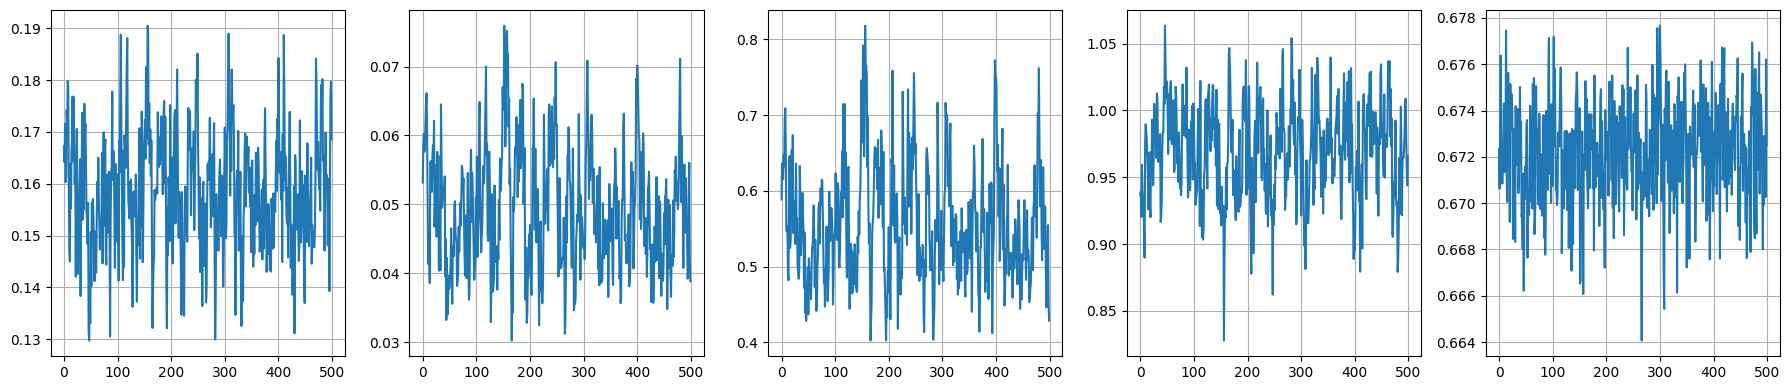

In [43]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(samples_nle[:, i])
    ax[i].grid(which='both')
plt.tight_layout()

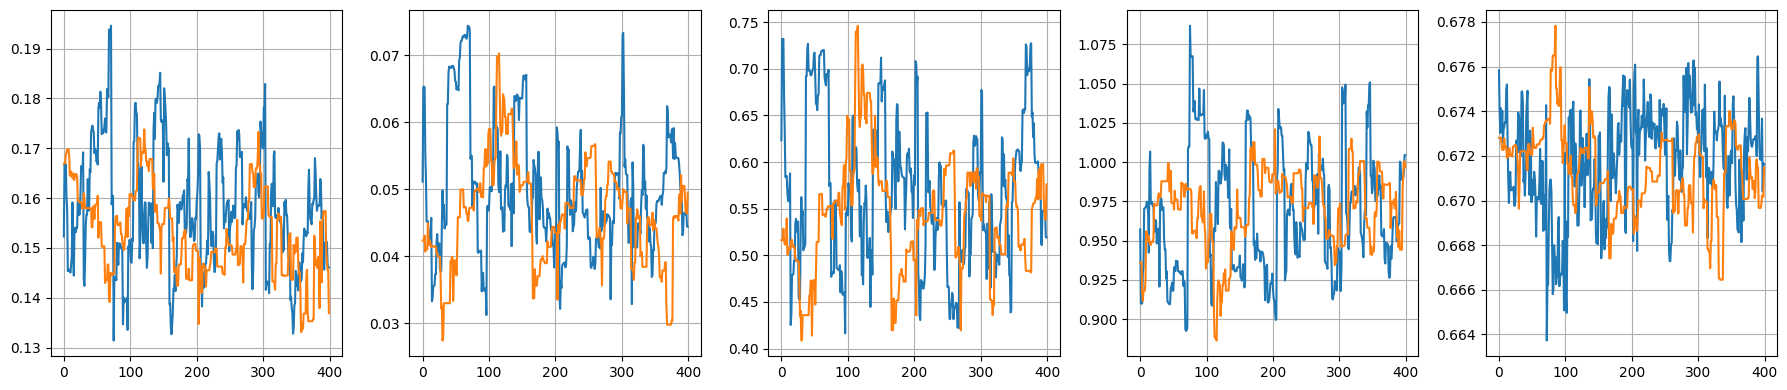

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i in range(5):
    ax[i].plot(chain[:, 0, i])
    ax[i].plot(chain2[:, 0, i])
    ax[i].grid(which='both')
plt.tight_layout()

array([0.1001 , 0.03001, 0.5001 , 0.8001 , 0.6001 ])

AttributeError: 'Axes' object has no attribute 'seet_xlim'

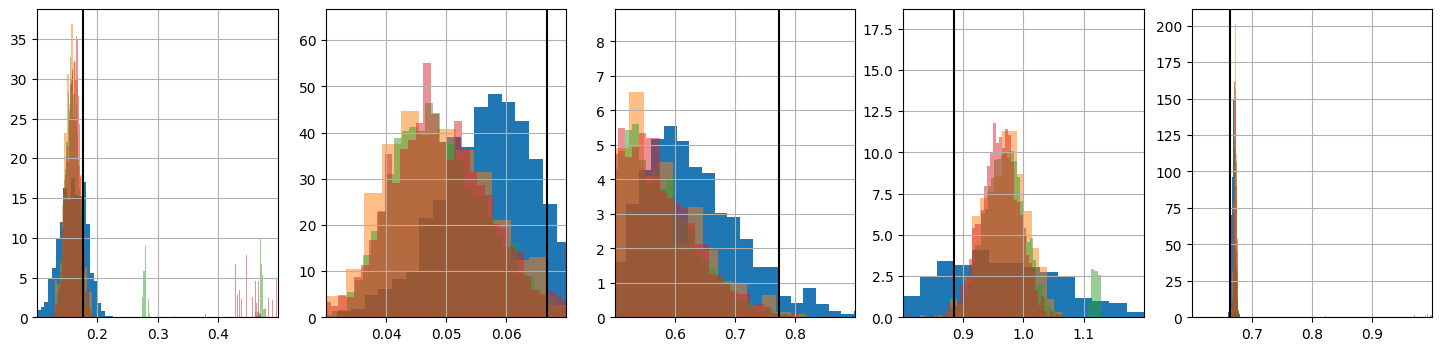

In [58]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))

j = 0 
for i in range(5):
    ax[i].hist(samples[j][:, i], density=True, bins='auto')
    ax[i].hist(samples_nle[:, i], alpha=0.5, density=True, bins='auto')
    ax[i].hist(chain[..., i].flatten(), alpha=0.5, density=True, bins='auto')
    ax[i].hist(chain2[..., i].flatten(), alpha=0.5, density=True, bins='auto')
    ax[i].axvline(params[j, i], color='k')
    ax[i].grid(which='both')
    ax[i].set_xlim(params.min(axis=0)[i], params.max(axis=0)[i])
ax[i].seet_xlim(0.65, 0.7)
plt.tight_layout()

In [37]:
# sbiplots.plot_posterior(trainx[j].copy(), trainy[j].copy(), posterior_nle)

#  Sub boxes

In [82]:
psubs = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split4.npy')
ksub  = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split4.npy')
# p2 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power_split4.npy').real
# k1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split2.npy')
idx = (ksub > 0.15) & (ksub < 0.5)
ksub = ksub[idx]
psubs = psubs[..., idx]
print(ksub.shape, psubs.shape)

(56,) (2000, 64, 56)


In [83]:
### SBI
trainxsub, scalersub = sbitools.standardize(psubs[:, 0, :], secondary=None, log_transform=True)
trainysub = params.copy()
priorsub = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
posteriorsub, inferencesub, summarysub = sbitools.sbi(trainxsub, trainysub, priorsub, \
                                            summarize=True,
                                            verbose=True, 
                                             nlayers=8, alg='snpe')

Training a new NF
 Neural network successfully converged after 102 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 102
        Best validation performance: 8.5369
        -------------------------
        


In [84]:
# i = 3
# fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)
# fig, ax = sbiplots.plot_posterior(trainxsub[i], trainysub[i], posteriorsub)

nsims, nsamples = 300, 1000
samples = np.zeros([nsims, nsamples, params.shape[1]])
samplessub = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(nsims):
    if j%20 ==0 : print(j)
    x = trainx[j].copy()
    samples[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    x = trainxsub[j].copy()
    samplessub[j] = posteriorsub.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()

    

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280


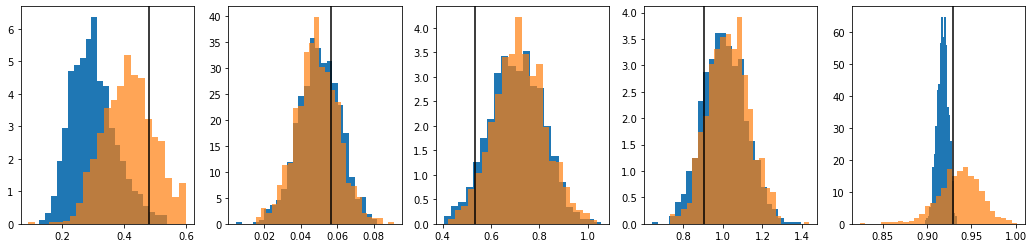

In [85]:
isim = 5 

fig, ax = plt.subplots(1, 5, figsize=(18, 4))

j = 0 
for i in range(5):
    ax[i].hist(samples[isim][:, i], density=True, bins='auto')
    ax[i].hist(samplessub[isim][:, i], density=True, bins='auto', alpha=0.7)
    ax[i].axvline(params[isim, i], color='k')


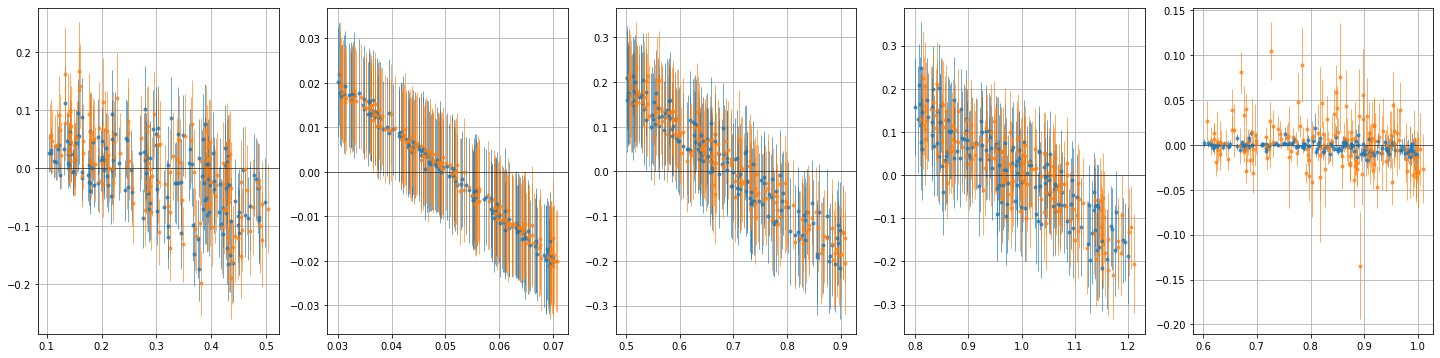

In [86]:
isim = 5 

fig, ax = plt.subplots(1, 5, figsize=(25, 6))

j = 0 
skip = 2
for i in range(5):
    # ax[i].errorbar(params[:100:skip, i], samples[::skip,:, i].mean(axis=1), samples[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.7)
    # ax[i].errorbar(params[:100:skip, i]*1.01, samplessub[::skip,:, i].mean(axis=1), samplessub[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.7)
    # ax[i].plot([params[..., i].min(), params[..., i].max()], [params[..., i].min(), params[..., i].max()], 'k')
    
    ax[i].errorbar(params[:nsims:skip, i], samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i], 
                   samples[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.9)
    ax[i].errorbar(params[:nsims:skip, i]*1.01, samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i],
                   samplessub[::skip,:, i].std(axis=1), fmt='.', alpha=0.7, elinewidth=0.9)
    ax[i].axhline(0., color='k', lw=0.5)
    ax[i].grid(which='both')

(array([0.00921483, 0.        , 0.        , 0.00921483, 0.01842965,
        0.0368593 , 0.07371861, 0.18429652, 0.26722995, 0.35016339,
        0.44231165, 0.36859304, 0.35937821, 0.22115582, 0.19351135,
        0.09214826, 0.04607413, 0.05528896, 0.00921483, 0.00921483,
        0.01842965]),
 array([-4.06180656, -3.70007066, -3.33833477, -2.97659887, -2.61486297,
        -2.25312707, -1.89139118, -1.52965528, -1.16791938, -0.80618349,
        -0.44444759, -0.08271169,  0.27902421,  0.6407601 ,  1.002496  ,
         1.3642319 ,  1.72596779,  2.08770369,  2.44943959,  2.81117548,
         3.17291138,  3.53464728]),
 <BarContainer object of 21 artists>)

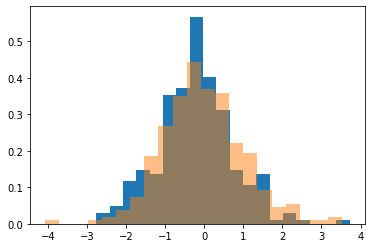

In [87]:
skip = 1
bias = (samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i])/samples[::skip,:, i].std(axis=1)
plt.hist(bias, bins='auto', density=True)
bias = (samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i])/samplessub[::skip,:, i].std(axis=1)
plt.hist(bias, alpha=0.5, bins='auto', density=True)

# skip = 1
# bias = (samples[::skip,:, i].mean(axis=1)-params[:nsims:skip, i]) #/samples[::skip,:, i].std(axis=1)
# plt.hist(bias, bins='auto', density=True)
# bias = (samplessub[::skip,:, i].mean(axis=1)-params[:nsims:skip, i]) #/samplessub[::skip,:, i].std(axis=1)
# plt.hist(bias, alpha=0.5, bins='auto', density=True);


# hybrid

In [138]:
psubs = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/power_split4.npy')
ksub  = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split4.npy')
# p2 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/0000/power_split4.npy').real
# k1 = np.load('/mnt/ceph/users/cmodi/Quijote/latin_hypercube_HR/matter/N0256/k_split2.npy')
idx = (ksub > 0.15) & (ksub < 0.5)
ksub = ksub[idx]
psubs = psubs[..., idx]
print(ksub.shape, psubs.shape)

trainxhy, scalerhy = sbitools.standardize(psubs[:, 0, :], secondary=None, log_transform=True)


(56,) (2000, 64, 56)


In [139]:
pfull = np.load('/mnt/home/cmodi/Research/Projects/HySBI/data/pkmatter_quijote.npy')[:, 1:]
kfull, pfull = pfull[0, :, 0], pfull[..., 1]
idx = (kfull <= 0.15)
kfull = kfull[idx]
pfull = pfull[:, idx]
pkcond, scaler_pkcond = sbitools.standardize(pfull, secondary=None, log_transform=True)

trainyhy = np.concatenate([params, pkcond], axis=-1)


In [143]:
trainyhy.shape

(2000, 28)

In [148]:
# ### SBI
# priorhy = sbitools.sbi_prior(params.reshape(-1, params.shape[-1]), offset=0.2)
# posteriorhy, inferencehy, summaryhy = sbitools.sbi(trainxhy, trainyhy, priorhy, \
#                                             summarize=True,
#                                             verbose=True, 
#                                              nlayers=8, alg='snpe')


priorhy = sbitools.sbi_prior(trainyhy, offset=0.2, device='cpu')
density_estimator_build_fun = likelihood_nn(model='maf', \
                                           hidden_features=32, \
                                           num_transforms=8,
                                           num_blocks=2)

inference_nle = SNLE_A(prior=prior, density_estimator=density_estimator_build_fun, device='cpu')
inference_nle.append_simulations(x= torch.from_numpy(trainxhy.astype('float32')), 
                            theta= torch.from_numpy(trainyhy.astype('float32')))

density_estimator_nle = inference_nle.train(training_batch_size=32,
                                        validation_fraction=0.1,
                                        learning_rate=5e-4,
                                        show_train_summary=True)

posterior_nle = inference_nle.build_posterior(density_estimator_nle)



 Neural network successfully converged after 90 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 90
        Best validation performance: 19.2041
        -------------------------
        


In [ ]:
# i = 3
# fig, ax = sbiplots.plot_posterior(trainx[i], trainy[i], posterior)
# fig, ax = sbiplots.plot_posterior(trainxsub[i], trainysub[i], posteriorsub)

nsims, nsamples = 300, 1000
sampleshy = np.zeros([nsims, nsamples, params.shape[1]])
for j in range(nsims):
    if j%20 ==0 : print(j)
    x = trainxhy[j].copy()
    sampleshy[j] = posterior.sample((nsamples,), x=torch.from_numpy(x.astype('float32')), show_progress_bars=False).detach().numpy()
    
    

# ensemble

In [9]:
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
import yaml
api = wandb.Api()


In [11]:

def insert_sweep_name(path):
    if '%s' in path:
        dirname = '/'.join(cfg_path.split('/')[:-2])
    else:
        dirname = path
    print(f"In directory {dirname}")
    for root, dirs, files in os.walk(dirname):
        if len(dirs) > 1 :
            print('More than 1 sweeps, abort!')
            raise
        break
    print(f"Sweep found : {dirs[0]}")
    if '%s' in path:
        return path%dirs[0]
    else:
        return path + f'/{dirs[0]}/'


def setup_cfg(cfg_path, verbose=False):

    cfg_path = insert_sweep_name(cfg_path)
    # print(cfg_path)
    cfg_dict = yaml.load(open(f'{cfg_path}/sweep_config.yaml'), Loader=yaml.Loader)
    sweep_id = cfg_dict['sweep']['id']
    sweep = api.sweep(f'modichirag92/hysbi/{sweep_id}')
    #sort in the order of validation log prob
    names, log_prob = [], []
    for run in sweep.runs:
        if run.state == 'finished':
            # print(run.name, run.summary['best_validation_log_prob'])
            try:
                model_path = run.summary['output_directory']
                names.append(run.name)
                log_prob.append(run.summary['best_validation_log_prob'])
            except Exception as e:
                print('Exception in checking state of run : ', e)
    idx = np.argsort(log_prob)[::-1]
    names = np.array(names)[idx]

    args = {}
    for i in cfg_dict.keys():
        args.update(**cfg_dict[i])
    cfg = sbitools.Objectify(**args)
    cfg.analysis_path = loader_pk.folder_path(cfg_dict, verbose=verbose)
    scaler = sbitools.load_scaler(cfg.analysis_path)

    toret = {'sweepid':sweep_id, 'cfg':cfg, 'idx':idx, 'scaler':scaler, 'names':names, 'cfg_dict':cfg_dict}
    return toret


cfg_p = '/mnt/ceph/users/cmodi/HySBI/matter/snpe/kmax0.5-kmin0.001-logit-offset_amp10000.0-standardize/'
cfg_p = setup_cfg(cfg_p)
cfg_l = '/mnt/ceph/users/cmodi/HySBI/matter/snle/kmax0.5-kmin0.001-logit-standardize//'
cfg_l = setup_cfg(cfg_l)

In directory /mnt/ceph/users/cmodi/HySBI/matter/snpe/kmax0.5-kmin0.001-logit-offset_amp10000.0-standardize/
Sweep found : ucv8endc
Exception in checking state of run :  'output_directory'
In directory /mnt/ceph/users/cmodi/HySBI/matter/snle/kmax0.5-kmin0.001-logit-standardize//
Sweep found : i4zca035


In [12]:
features_p, params_p = loader_pk.loader(cfg_p['cfg'])
features_l, params_l = loader_pk.loader(cfg_l['cfg'])

Loaded power spectrum data with shape :  (2000, 128)
Offset power spectra with amplitude: 10000.0
pk shape after k-cuts :  (2000, 79)
offset shape:  (2000, 1)
Params shape after adding offset:  (2000, 6)
Loaded power spectrum data with shape :  (2000, 128)
pk shape after k-cuts :  (2000, 79)


In [13]:
def get_samples(features, sweepdict, standardize=True, nposterior=1, nsamples=1000, cosmoonly=True, verbose=False):
    sweepid = sweepdict['sweepid']
    if standardize:
        if len(features.shape) == 1: features = features.reshape(1, -1)
        features = sbitools.standardize(features, scaler=sweepdict['scaler'], log_transform=sweepdict['cfg'].logit)[0]
    
    posteriors = []
    for j in range(nposterior):
        name = sweepdict['names'][j]
        if verbose: print(name)
        model_path = f"{sweepdict['cfg'].analysis_path}/{sweepid}/{name}/"
        posteriors.append(sbitools.load_posterior(model_path))
    posterior = NeuralPosteriorEnsemble(posteriors=posteriors)
    samples = posterior.sample((nsamples,), x=torch.from_numpy(features.astype('float32')), show_progress_bars=verbose).detach().numpy()
    if cosmoonly: return np.array(samples)[:, :5]
    else: return np.array(samples)


isim = 0
samples_p = get_samples(features_p[isim], cfg_p, nposterior=5)
# samples_l = get_samples(features_l[isim], cfg_l, nposterior=5)

In [138]:
# samples_l = get_samples(features_l[isim], cfg_l, nposterior=5, verbose=True)
samples_l2 = get_samples(features_l[isim], cfg_l, nposterior=1, verbose=False, nsamples=100)

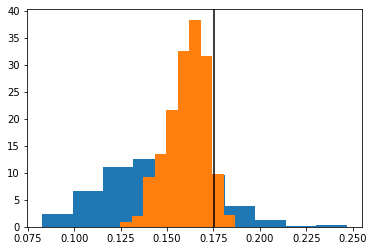

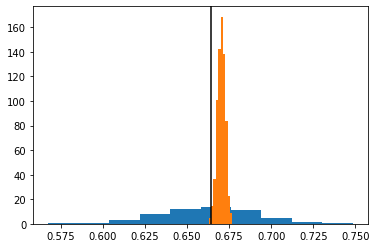

In [20]:
idim = 0 
plt.hist(samples_p[:, idim], density=True)
plt.hist(samples_l[:, idim], density=True)
plt.axvline(params_p[isim, idim], color='k')
plt.show()
idim = 4 
plt.hist(samples_p[:, idim], density=True)
plt.hist(samples_l[:, idim], density=True)
plt.axvline(params_p[isim, idim], color='k')

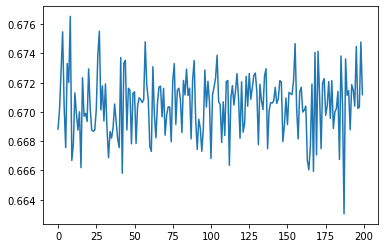

In [27]:
idim = 4
plt.plot(samples_l[:200, idim])

In [63]:
def ensemble_logprob_snle(features, sweepdict, standardize=True, nposterior=1, track_gradients=False, batch=2):
    sweepid = sweepdict['sweepid']
    if standardize:
        if len(features.shape) == 1: features = features.reshape(1, -1)
        features = sbitools.standardize(features, scaler=sweepdict['scaler'], log_transform=sweepdict['cfg'].logit)[0]
    
    posteriors = []
    for j in range(nposterior):
        name = sweepdict['names'][j]
        model_path = f"{sweepdict['cfg'].analysis_path}/{sweepid}/{name}/"
        posteriors.append(sbitools.load_posterior(model_path))

    # x = torch.from_numpy(features.reshape(1, -1).astype(np.float32))
    features = np.array([features]*batch).reshape(batch, features.shape[-1])
    x = torch.from_numpy(features.astype(np.float32))
    print(x.shape)
    
    def log_prob(theta, x):
        # theta = torch.from_numpy(theta.reshape(batch, -1).astype(np.float32))#.to('cuda')
        batch = theta.shape[0]
        theta = torch.from_numpy(theta.astype(np.float32))
        x = np.array([x]*batch).reshape(batch, x.shape[-1])
        x = torch.from_numpy(x.astype(np.float32))

        lp = 0.        
        
        for p in posteriors:
            lp += p.potential_fn.likelihood_estimator.log_prob(x, theta).detach().numpy()
        lp /= len(posteriors)
        
        lp += posteriors[0].potential_fn.prior.log_prob(theta).detach().numpy()
        return lp
    
    
    return log_prob


In [64]:
# p.potential_fn.likelihood_estimator.log_prob(x, theta).detach().numpy()

In [73]:
isim = 0
lp_ens = ensemble_logprob_snle(features_l[isim], cfg_l, nposterior=5, batch=1)
lp_ens(params[np.random.randint(0, 2000, 4)], features[0])

%timeit lp_ens(params[np.random.randint(0, 2000)], features[0])

torch.Size([1, 79])
19.3 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
isim = 0
batch = 16
lp_ens = ensemble_logprob_snle(features_l[isim], cfg_l, nposterior=5, batch=batch)
lp_ens(params[np.random.randint(0, 2000, batch)], features[0])

%timeit lp_ens(params[np.random.randint(0, 2000, batch)], features[0])

torch.Size([16, 79])
22.2 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## emcee it

In [78]:
nsteps, nwalkers, ndim = 100, 2*batch, 5
burn_in = 10 
thin = 1
x0 = params[:nwalkers]
start = time.time()
print('emcee it')
sampler = emcee.EnsembleSampler(nwalkers, ndim, lp_ens, vectorize=True, args=(features[0],))
sampler.run_mcmc(x0, nsteps + burn_in, progress=True)
chain = sampler.get_chain(flat=False, discard=burn_in, thin=thin)
print("Time taken : ", time.time()-start)


emcee it


100%|██████████| 110/110 [00:04<00:00, 22.56it/s]

Time taken :  4.911663293838501


In [77]:
snpe_samples = posterior.sample((1000,), x=torch.from_numpy(trainx[0].astype('float32')), show_progress_bars=False).detach().numpy()


NameError: name 'posterior' is not defined

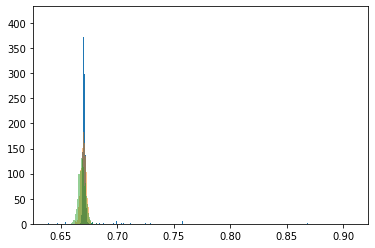

In [249]:
idim = 4 
plt.hist(chain[..., idim].flatten(), bins='auto', density=True);
plt.hist(samples_l[..., idim].flatten(), bins='auto', alpha=0.5, density=True);
# plt.hist(samples_p[..., idim].flatten(), bins='auto', alpha=0.5);
plt.hist(snpe_samples[..., idim].flatten(), bins='auto', alpha=0.5, density=True);
# plt.hist(samples_l2[..., idim].flatten(), bins='auto');


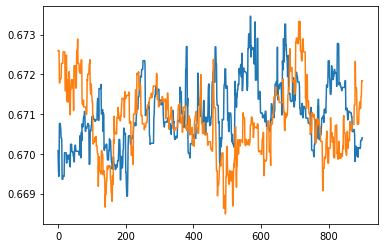

In [219]:
plt.plot(chain[100:, 0, idim])
plt.plot(chain[100:, 2, idim])

# plot runs


In [19]:
testidx = np.load('/mnt/ceph/users/cmodi/HySBI/test-train-splits/test-N2000-f0.15-S0.npy')
testidx;

Text(0.5, 0.98, 'LH1447')

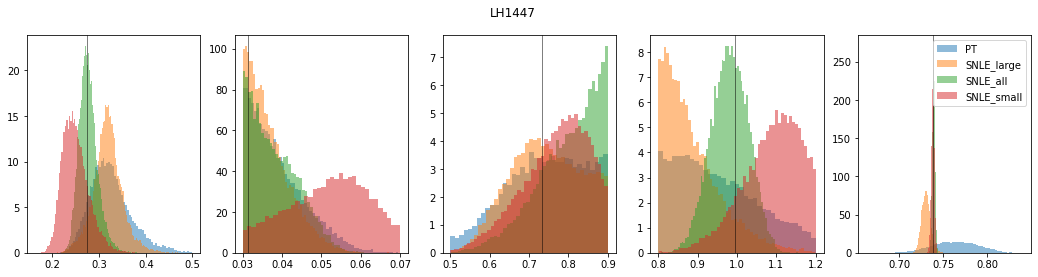

In [92]:
isim = testidx[4]

f0 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/PT/emcee_chains/LH{isim}_kmax0.15.npy')
f1 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.15-kmin0.001-logit-standardize/LH{isim}.npy')
f2 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.001-logit-standardize/LH{isim}.npy')
f3 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/snle/emcee_chains/kmax0.5-kmin0.15-logit-standardize/LH{isim}.npy')
# f4 = np.load(f'/mnt/ceph/users/cmodi/HySBI/matter/samples/hybrid/emcee_chains/kmax0.5-kmin0.15-logit-nsubs1-splits2-standardize/LH0.npy')

fig, ax = plt.subplots(1, 5 , figsize=(18, 4))

for i in range(5):
    ax[i].hist(f0[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='PT');
    ax[i].hist(f1[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_large');
    ax[i].hist(f2[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_all');
    ax[i].hist(f3[..., i].flatten(), alpha=0.5, density=True, bins='auto', label='SNLE_small');
    ax[i].axvline(params[isim][i], color='k', lw=0.5)
    
ax[-1].legend()
plt.suptitle(f'LH{isim}')

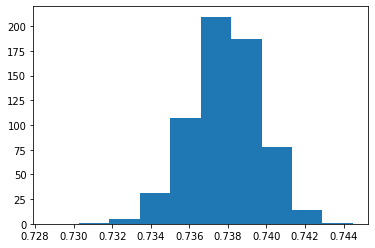

In [105]:
# plt.hist(f0[..., -1].flatten(), density=True);
plt.hist(f3[..., -1].flatten(), density=True);

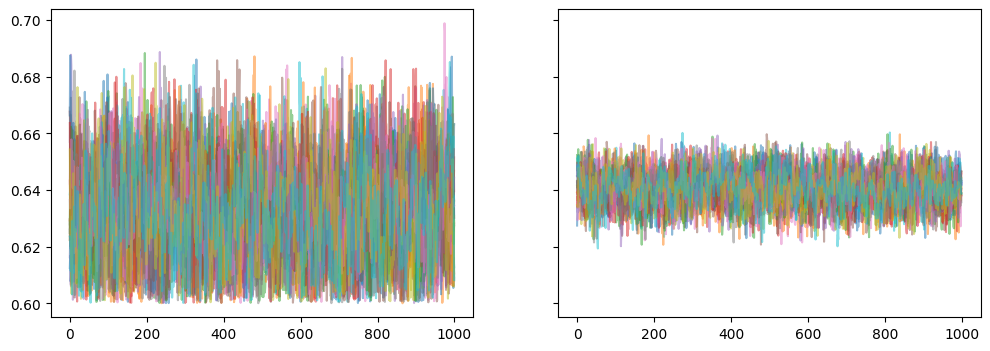

In [180]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
idim = 4

for j in range(20):
    ax[0].plot(f0[:, j, idim], alpha=0.5)
# plt.axhline(params.min(axis=0)[idim], color='k')
# plt.axhline(params.max(axis=0)[idim], color='k')

plt.subplot(122)
for j in range(20):
    ax[1].plot(f1[:, j, idim], alpha=0.5)
# plt.axhline(params.min(axis=0)[idim], color='k')
# plt.axhline(params.max(axis=0)[idim], color='k')

# rankplots

In [107]:
samples = []
for i in range(300):
    isim = testidx[i]
    ss = np.load(